In [2]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB

# Caricamento dei dati
df = pd.read_csv('../data.csv')
W = 500
t_values = [1000, 2000, 3000, 4000, 4500]

# Liste per salvare i risultati
varianza_prima_ottimizzazione = []
valore_atteso_prima_ottimizzazione = []
varianza_seconda_ottimizzazione = []
valore_atteso_seconda_ottimizzazione = []

# Funzione di callback per interrompere l'ottimizzazione se non ci sono miglioramenti
class MyCallback:
    def __init__(self, max_time_without_improvement, optimization):
        self.last_best_gap = float('inf')
        self.last_improvement_time = 0
        self.max_time_without_improvement = max_time_without_improvement
        self.optimization = optimization
    
    def callback(self, model, where):
        if where == GRB.Callback.MIP:
            # Recupera il gap attuale (in percentuale) e lo arrotonda a una cifra decimale
            best_obj = model.cbGet(GRB.Callback.MIP_OBJBST)
            best_bd = model.cbGet(GRB.Callback.MIP_OBJBND)
            if best_obj != 0:
                current_gap = (abs(best_obj - best_bd) / abs(best_obj))*100
            else:
                current_gap = (abs(best_obj - best_bd))*100
            
            # Arrotonda il gap a una cifra decimale
            current_gap = round(current_gap, 1)
            
            runtime = model.cbGet(GRB.Callback.RUNTIME)
            
            if current_gap != self.last_best_gap:
                self.last_best_gap = current_gap
                self.last_improvement_time = runtime
                self.last_printed_time = 0  # Reset dell'ultimo tempo stampato
            elif runtime - self.last_improvement_time > self.max_time_without_improvement:
                print("Exceeded the maximum time without significant improvements in the gap")
                model.terminate()
            else:
                time_since_last_improvement = runtime - self.last_improvement_time
                next_multiple_of_60 = (self.last_printed_time // 60 + 1) * 60
                if time_since_last_improvement >= next_multiple_of_60:
                    self.last_printed_time = time_since_last_improvement
                    minutes_since_last_improvement = time_since_last_improvement // 60
                    print(f"{minutes_since_last_improvement:.1f} minute(s) with no significant improvement in the gap")
                    print(f"Last significant improvement time: {self.last_improvement_time}")
                    print(f"Current gap: {current_gap:.1f}")

# Funzione per eseguire le ottimizzazioni e stampare i risultati
def optimize_and_save_results(t):
    # Filtraggio dei dati per la finestra temporale
    window_data = df[(df['SampleTime'] >= t - W) & (df['SampleTime'] <= t)]

    # Pivot table per avere un formato adatto all'ottimizzazione
    pivot_data = window_data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)

    # Calcolo della penalizzazione basata sul numero di valori nulli originali
    null_counts = window_data.pivot(index='SampleTime', columns='SensorID', values='Value').isna().sum()
    penalty = null_counts / null_counts.max()  # Normalizzare la penalizzazione tra 0 e 1

    # Filtrare le colonne con tutti valori nulli
    pivot_data = pivot_data.dropna(axis=1, how='all')

    # Calcolo di media e varianza
    mean_vector = pivot_data.mean(axis=0, skipna=True).values
    cov_matrix = pivot_data.cov().values

    # Creare un dizionario per la penalizzazione con i nuovi indici
    penalty_dict = penalty[pivot_data.columns].to_dict()

    # Definizione dei parametri
    n = len(mean_vector)
    B = 10
    delta = 0.001 # Soglia minima per alpha

    # Numero di thread da utilizzare
    num_threads = 8
    max_time_without_improvement = 600  # Tempo in secondi per fermare se BestBd non viene aggiornato

    # Creazione del modello per la prima ottimizzazione
    model1 = Model()

    # Impostazione del numero di thread e del callback
    model1.setParam('Threads', num_threads)

    # Aggiunta delle variabili
    alpha1 = model1.addVars(n, lb=0, ub=1, name="alpha1")
    b1 = model1.addVars(n, vtype=GRB.BINARY, name="b1")

    # Funzione obiettivo: minimizzare la varianza di Y
    var_Y1 = sum(alpha1[i] * alpha1[j] * cov_matrix[i, j] for i in range(n) for j in range(n))
    penalized_var_Y1 = var_Y1 + sum(penalty_dict[pivot_data.columns[i]] * alpha1[i] for i in range(n))  # Aggiungere la penalizzazione
    model1.setObjective(penalized_var_Y1, GRB.MINIMIZE)

    # Vincoli
    model1.addConstr(sum(alpha1[i] for i in range(n)) == 1, "sum_alpha1")
    model1.addConstr(sum(b1[i] for i in range(n)) == B, "sum_b1")
    for i in range(n):
        model1.addConstr(alpha1[i] <= b1[i], f"alpha1_b1_{i}")
        model1.addConstr(alpha1[i] >= delta * b1[i], f"alpha1_min_{i}")  # Nuovo vincolo per la soglia minima di alpha

    # Risoluzione del modello con callback
    callback1 = MyCallback(max_time_without_improvement, 0)
    model1.optimize(callback1.callback)

    # Estrazione dei risultati della prima ottimizzazione
    alpha_values1 = model1.getAttr('x', alpha1)
    b_values1 = model1.getAttr('x', b1)
    selected_sensors1 = [(pivot_data.columns[i], alpha_values1[i]) for i in range(n) if alpha_values1[i] > 0]

    # Calcolo della varianza minima ottenuta
    varianza_minima = sum(alpha_values1[i] * alpha_values1[j] * cov_matrix[i, j] for i in range(n) for j in range(n))

    # Calcolo del valore atteso dopo la prima ottimizzazione
    expected_value1 = sum(alpha_values1[i] * mean_vector[i] for i in range(n))

    # Salvataggio dei risultati della prima ottimizzazione
    varianza_prima_ottimizzazione.append(varianza_minima)
    valore_atteso_prima_ottimizzazione.append(expected_value1)

    # Stampa dei risultati della prima ottimizzazione
    print(f"Risultati Prima Ottimizzazione per t = {t}:")
    print("I 10 alpha diversi da 0 con i relativi SensorID:")
    for i, val in sorted(selected_sensors1, key=lambda x: x[1], reverse=True)[:10]:
        print(f"SensorID: {i}, alpha: {val}")
    alpha_sum1 = sum(val for _, val in selected_sensors1)
    print(f"Somma degli alpha diversi da 0: {alpha_sum1}")
    print(f"Varianza: {varianza_minima}")
    print(f"Valore atteso: {expected_value1}")

    # Creazione del modello per la seconda ottimizzazione
    model2 = Model()

    # Impostazione del numero di thread e del callback
    model2.setParam('Threads', num_threads)

    # Aggiunta delle variabili
    alpha2 = model2.addVars(n, lb=0, ub=1, name="alpha2")
    b2 = model2.addVars(n, vtype=GRB.BINARY, name="b2")

    # Funzione obiettivo: massimizzare il valore atteso di Y
    expected_Y = sum(alpha2[i] * mean_vector[i] for i in range(n))
    penalized_expected_Y = expected_Y - sum(penalty_dict[pivot_data.columns[i]] * alpha2[i] for i in range(n))  # Aggiungere la penalizzazione
    model2.setObjective(penalized_expected_Y, GRB.MAXIMIZE)

    # Vincoli
    model2.addConstr(sum(alpha2[i] for i in range(n)) == 1, "sum_alpha2")
    model2.addConstr(sum(b2[i] for i in range(n)) <= B, "sum_b2")
    for i in range(n):
        model2.addConstr(alpha2[i] <= b2[i], f"alpha2_b2_{i}")
        model2.addConstr(alpha2[i] >= delta * b2[i], f"alpha2_min_{i}")  # Nuovo vincolo per la soglia minima di alpha

    # Vincolo sulla varianza con tolleranza
    epsilon = 1e-6
    var_Y2 = sum(alpha2[i] * alpha2[j] * cov_matrix[i, j] for i in range(n) for j in range(n))
    model2.addConstr(var_Y2 <= varianza_minima - epsilon, "var_constraint")

    # Vincolo per garantire che il valore atteso sia maggiore di quello dopo la prima ottimizzazione
    model2.addConstr(expected_Y >= expected_value1 + epsilon, "expected_value_constraint")

    try:
        # Risoluzione del modello con callback
        callback2 = MyCallback(max_time_without_improvement, 1)
        model2.optimize(callback2.callback)

        # Estrazione dei risultati della seconda ottimizzazione
        alpha_values2 = model2.getAttr('x', alpha2)
        b_values2 = model2.getAttr('x', b2)
        selected_sensors2 = [(pivot_data.columns[i], alpha_values2[i]) for i in range(n) if alpha_values2[i] > 0]

        # Calcolo del valore atteso e della varianza ottenuti
        expected_value2 = sum(alpha_values2[i] * mean_vector[i] for i in range(n))
        varianza_seconda_ottimizzazione_value = sum(alpha_values2[i] * alpha_values2[j] * cov_matrix[i, j] for i in range(n) for j in range(n))

        # Verifica dei vincoli della seconda ottimizzazione
        if varianza_seconda_ottimizzazione_value > varianza_minima or expected_value2 < expected_value1:
            print("Seconda ottimizzazione non ha migliorato i risultati. Verranno utilizzati gli alpha della prima ottimizzazione.")
            alpha_values2 = alpha_values1  # Copia gli alpha della prima ottimizzazione
            varianza_seconda_ottimizzazione_value = varianza_minima
            expected_value2 = expected_value1
            selected_sensors2 = [(pivot_data.columns[i], alpha_values2[i]) for i in range(n) if alpha_values2[i] > 0]
        else:
            print("Il vincolo di varianza è rispettato.")
            print("Il vincolo di valore atteso è rispettato.")

    except Exception as e:
        # In caso di errore, usa i valori della prima ottimizzazione
        print(f"Errore durante la seconda ottimizzazione: {str(e)}. Uso dei valori della prima ottimizzazione.")
        alpha_values2 = alpha_values1
        varianza_seconda_ottimizzazione_value = varianza_minima
        expected_value2 = expected_value1
        selected_sensors2 = [(pivot_data.columns[i], alpha_values1[i]) for i in range(n) if alpha_values1[i] > 0]

    # Salvataggio dei risultati della seconda ottimizzazione
    varianza_seconda_ottimizzazione.append(varianza_seconda_ottimizzazione_value)
    valore_atteso_seconda_ottimizzazione.append(expected_value2)

    # Stampa dei risultati della seconda ottimizzazione
    print(f"Risultati Seconda Ottimizzazione per t = {t}:")
    print("I 10 alpha diversi da 0 con i relativi SensorID:")
    for I, val in sorted(selected_sensors2, key=lambda x: x[1], reverse=True)[:10]:
        print(f"SensorID: {I}, alpha: {val}")
    alpha_sum2 = sum(val for _, val in selected_sensors2)
    print(f"Somma degli alpha diversi da 0: {alpha_sum2}")
    print(f"Varianza: {varianza_seconda_ottimizzazione_value}")
    print(f"Valore atteso: {expected_value2}")

# Esecuzione del ciclo per ogni valore di t
for t in t_values:
    print(f"Esecuzione per t = {t}")
    optimize_and_save_results(t)

Esecuzione per t = 1000
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1222 rows, 1220 columns and 3660 nonzeros
Model fingerprint: 0x3ff4affa
Model has 186355 quadratic objective terms
Variable types: 610 continuous, 610 integer (610 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-03, 1e+00]
  QObjective range [5e-09, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.0024181
Presolve time: 0.06s
Presolved: 1222 rows, 1220 columns, 3660 nonzeros
Presolved model has 186355 quadratic objective terms
Variable types: 610 continuous, 610 integer (610 binary)

Root relaxation: objective 1.168874e-05, 214 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds

In [3]:
# Caricamento dei dati
df = pd.read_csv('../data.csv')
W = 500
t_values = [1000, 2000, 3000, 4000, 4500]

# Liste per salvare i risultati
varianza_senza_ottimizzazione = []
valore_atteso_senza_ottimizzazione = []

# Funzione per calcolare varianza e valore atteso senza ottimizzazione
def calculate_without_optimization(t):
    # Filtraggio dei dati per la finestra temporale
    new_window_data = df[(df['SampleTime'] >= t - W) & (df['SampleTime'] <= t)]

    # Pivot table per avere un formato adatto al calcolo
    new_pivot_data = new_window_data.pivot(index='SampleTime', columns='SensorID', values='Value')

    # Calcolo di media e varianza per la nuova finestra temporale
    new_mean_vector = new_pivot_data.mean(axis=0, skipna=True).values
    new_cov_matrix = new_pivot_data.cov().values

    # Calcolo del valore atteso e della varianza senza applicare l'ottimizzazione degli alpha
    expected_value = np.nanmean(new_mean_vector)  # Media dei valori dei sensori
    variance = np.nanmean(new_cov_matrix)  # Media della matrice di covarianza

    # Salvataggio dei risultati
    varianza_senza_ottimizzazione.append(variance)
    valore_atteso_senza_ottimizzazione.append(expected_value)

    # Stampa dei risultati
    print(f"Risultati senza ottimizzazione per t = {t}:")
    print(f"Varianza: {variance}")
    print(f"Valore atteso: {expected_value}")

# Esecuzione del ciclo per ogni valore di t
for t in t_values:
    print(f"Esecuzione per t = {t}")
    calculate_without_optimization(t)

# Risultati finali
print("Risultati finali senza ottimizzazione:")
print(f"Varianza Senza Ottimizzazione: {varianza_senza_ottimizzazione}")
print(f"Valore Atteso Senza Ottimizzazione: {valore_atteso_senza_ottimizzazione}")

Esecuzione per t = 1000
Risultati senza ottimizzazione per t = 1000:
Varianza: 0.00010766178306719575
Valore atteso: 0.000884215109460695
Esecuzione per t = 2000
Risultati senza ottimizzazione per t = 2000:
Varianza: 6.573348699221575e-05
Valore atteso: 0.0009625016594762733
Esecuzione per t = 3000
Risultati senza ottimizzazione per t = 3000:
Varianza: 0.00015292391115514007
Valore atteso: 0.0002912387995496778
Esecuzione per t = 4000
Risultati senza ottimizzazione per t = 4000:
Varianza: 5.3732459207400065e-05
Valore atteso: 0.0004660549249497154
Esecuzione per t = 4500
Risultati senza ottimizzazione per t = 4500:
Varianza: 5.7279383657791265e-05
Valore atteso: 0.0007148366562668417
Risultati finali senza ottimizzazione:
Varianza Senza Ottimizzazione: [0.00010766178306719575, 6.573348699221575e-05, 0.00015292391115514007, 5.3732459207400065e-05, 5.7279383657791265e-05]
Valore Atteso Senza Ottimizzazione: [0.000884215109460695, 0.0009625016594762733, 0.0002912387995496778, 0.0004660549

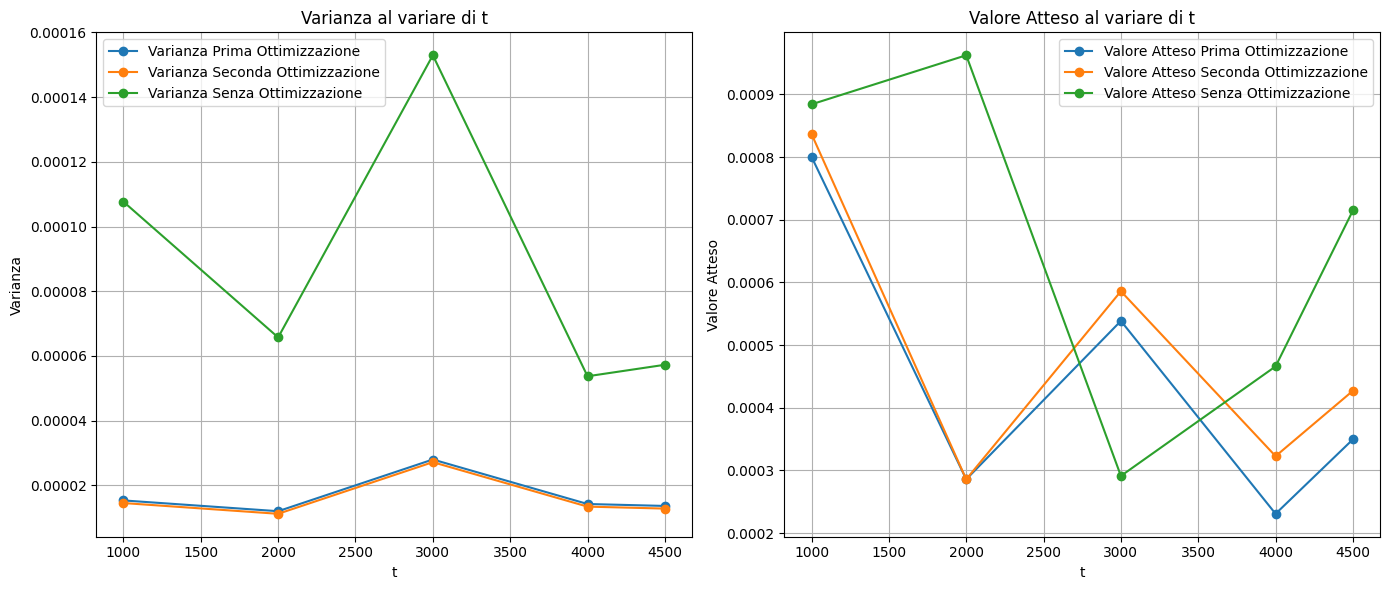

In [4]:
import matplotlib.pyplot as plt

# Offset per evitare sovrapposizioni complete
offset = 4e-7

# Applicazione degli offset alle varianze
varianza_prima_offset = [v + offset for v in varianza_prima_ottimizzazione]
varianza_seconda_offset = [v - offset for v in varianza_seconda_ottimizzazione]

# Plot della varianza
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t_values, varianza_prima_offset, label='Varianza Prima Ottimizzazione', marker='o')
plt.plot(t_values, varianza_seconda_offset, label='Varianza Seconda Ottimizzazione', marker='o')
plt.plot(t_values, varianza_senza_ottimizzazione, label='Varianza Senza Ottimizzazione', marker='o')
plt.xlabel('t')
plt.ylabel('Varianza')
plt.title('Varianza al variare di t')
plt.legend()
plt.grid(True)

# Plot del valore atteso
plt.subplot(1, 2, 2)
plt.plot(t_values, valore_atteso_prima_ottimizzazione, label='Valore Atteso Prima Ottimizzazione', marker='o')
plt.plot(t_values, valore_atteso_seconda_ottimizzazione, label='Valore Atteso Seconda Ottimizzazione', marker='o')
plt.plot(t_values, valore_atteso_senza_ottimizzazione, label='Valore Atteso Senza Ottimizzazione', marker='o')
plt.xlabel('t')
plt.ylabel('Valore Atteso')
plt.title('Valore Atteso al variare di t')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()